# <font color='004C99'>**Machine Learning and Pattern Recognition CO2 Project Work**</font>
## <font color='0066CC'>**Sepsis Mars Endotype and Survival Prediction through Gene Expression**</font>
##### Participants: Daniela Charraga Garcia, Flavia D'Eramo, Jolafin Hostettler

### <font color='skyblue'>**Project Overview and Research Question**</font>

Sepsis is a life-threatening condition where the body’s response to infection becomes dysregulated. A key challenge is that two patients with sepsis can look similar clinically but have very different underlying immune responses and outcomes.

In their paper, Scicluna et. al used whole-blood transcriptomic profiles from ICU patients with sepsis to address the problem with the heterogeneity in the sepsis diagnosis. They applied unsupervised learning to the gene expression data to identify four molecular endotypes (Mars1–Mars4). The aim was to discover data-driven subgroups that reflect different host-response patterns and that could help with risk stratification and therefore more tailored treatment decisions. In the paper, these endotypes were linked to clinical traits and differences in mortality risk.

In this project, we “work backwards” from that idea using a supervised learning approach and ask; "Can we learn to predict the published MARS endotypes (Mars1–Mars4) from baseline whole-blood transcriptomic data, and do these predicted endotypes still stratify 28-day mortality risk?"

To answer this, we compare a baseline linear model to more flexible models, tune hyperparameters using cross-validation, and evaluate performance on held-out data. We then relate endotype predictions to 28-day mortality to check whether the stratification signal remains visible in our modelling pipeline.

### <font color='skyblue'>**Dataset and Matrices preparation**</font>

#### <font color='lightblue'>***Dataset***</font>
We use the public GEO dataset GSE65682, generated on the Affymetrix U219 microarray platform. The dataset contains genome-wide gene expression profiles from adult ICU sepsis patients and healthy controls, alongside patient-level clinical metadata and outcomes including 28-day mortality

#### <font color='lightblue'>***Background on microarray measurements***</font>
Microarrays quantify RNA abundance for thousands of transcripts at once using probe sets designed for specific genes. After preprocessing, each sample becomes a vector of gene expression values (typically on a log scale), which can be used as input features for machine learning.

#### <font color='lightblue'>***How we accessed and built the working matrices***</font>
To keep the workflow reproducible, we rebuilt the expression matrix and metadata table from GEO (GEO accession GSE65682, https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE65682):
1. **Access expression data and metadata**

- Expression data and sample annotations were downloaded from GEO (GSE65682).
- Sample metadata were retrieved from the GEO series matrix (phenotype table).
2. **Normalization**

- The expression values used for modeling are based on a normalized microarray expression set (log-scale).
- The dataset is also available in processed form from GEO, which is the one that was used in this project
3. **Map probes to gene symbols**

- Microarrays measure probe sets rather than genes directly, so obtaining the expression matrix involves mapping each probe ID to a gene symbol
- Probes that could not be mapped to a gene symbol were removed.
4. **Collapse probes to a single gene value**

- Multiple probes can map to the same gene. For simplicity and to obtain a clean gene-level matrix, we collapsed probes by gene symbol using the mean expression across probes mapping to the same gene.
- This produces one value per gene per sample.
5. **Construct X and align with phenotype data**

- The final expression matrix X has shape samples × genes (479 sepsis samples with Mars endotypes; ~11k gene symbols after collapsing). 
- A matching phenotype/metadata table contains the endotype labels (Mars1–Mars4), cohort membership (discovery/validation), and outcomes (including 28-day mortality).
- Sample IDs were intersected and reordered so that the rows of X match the rows of the metadata exactly.

For this endotype-prediction task, we use transcriptomic features only (gene expression). Clinical covariates are kept for context and checks (e.g., cohort structure) and for downstream analysis of mortality stratification, but they are not used as predictors in the endotype models.

### <font color='skyblue'>**Project Workflow**</font>
1. **Exploration and sanity checks**

- Inspect class imbalance across Mars1–Mars4, check missingness, and use PCA to visualise major sources of variation (including checking whether discovery vs validation cohorts dominate the signal).
2. **Endotype prediction (supervised learning)**

- Train models to classify Mars1–Mars4 from baseline gene expression.
- Models used:
    - Logistic regression (baseline)
    - Random forest
    - SVM
    - Gradient Boosting
- Feature selection uses variance filtering inside cross-validation
- Performance is reported with macro-F1, balanced accuracy, and confusion matrices.
3. **Mortality analysis**

- Use the available 28-day outcome labels to examine whether predicted endotypes still stratify mortality risk in the expected direction (e.g., higher risk for Mars1 in the original study).
4. **Interpretation**

- Summarise which genes are retained by variance filtering and discuss how model performance and error patterns relate to the biological idea of the different host-response endotypes.

### <font color='skyblue'>**Related Work**</font>
- Scicluna et al. used unsupervised consensus clustering and random forests to discover and validate four blood genomic sepsis endotypes (Mars1–4) in MARS and external cohorts, showing strong associations with clinical traits and 28‑day and 1‑year mortality; they also derived parsimonious gene biomarkers for bedside endotype classification. (https://www.thelancet.com/journals/lanres/article/PIIS2213-2600(17)30294-1/fulltext)
​
- Komorowski et al. reviewed sepsis biomarkers and diagnostic tools based on machine learning. They pointed out that supervised models are widely used for sepsis diagnosis and mortality prediction, and that unsupervised phenotyping (e.g. Mars endotypes, SRS1/2) improves risk stratification and may guide treatment selection (https://pmc.ncbi.nlm.nih.gov/articles/PMC9783125/)

#### <font color='lightblue'>***Other References used***</font>
https://scikit-learn.org/stable/modules/cross_validation.html

- **Logistic Regression:** https://www.sciencedirect.com/science/article/pii/S235291482100112X, https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- **Random Forest:** https://pmc.ncbi.nlm.nih.gov/articles/PMC11283789/, https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- **Gradient Boosting:** https://pmc.ncbi.nlm.nih.gov/articles/PMC10060728/, https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
- **SVM:** https://noble.gs.washington.edu/papers/brown_knowledge_tr.pdf, https://scikit-learn.org/stable/modules/svm.html


### <font color='skyblue'>**Imports**</font>

In [2]:
# General data analysis and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# selfmade plotting script with plot functions
from plotting import (
    plot_counts,
    plot_counts_ax,
    plot_missingness_bar_ax,
    plot_missingness_hist_ax,
    plot_expression_distributions,
    plot_pca_ax,
    plot_cm_and_optional_roc,
    evaluate_multiclass
) 

# Preprocessing libraries
from sklearn.impute import SimpleImputer # + in modeling
from sklearn.preprocessing import StandardScaler, label_binarize # + in modeling
from sklearn.decomposition import PCA

# Machine learning libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay, balanced_accuracy_score, f1_score, log_loss
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.utils.validation import validate_data

# models used
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Parameter tuning
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [3]:
metadata = pd.read_csv("metadata.csv", index_col=0) # Prepared metadata file
xgene_data = pd.read_csv("gene_expression.csv", index_col=0) # Prepared gene expression file (process described above)

assert set(xgene_data.columns) == set(metadata.index) # sanity check if everything is still properly strcutured for further steps

#### <font color='lightblue'>***Freeze canonical data objects***</font>

In [10]:
geneX = xgene_data.copy()       # genes x samples
meta_aligned = metadata.copy()  # samples x metadata

geneX.columns = geneX.columns.astype(str).str.strip() # Standardize GSM identifiers
meta_aligned.index = meta_aligned.index.astype(str).str.strip()

common = geneX.columns.intersection(meta_aligned.index) # Inner-join on samples (GSM IDs) so expression and metadata refer to same samples

geneX = geneX.loc[:, common].copy()        # genes x common_samples
meta_aligned = meta_aligned.loc[common].copy()  # common_samples x metadata
X_all = geneX.T.copy() # Create the canonical analysis matrix (samples x genes)

# Sanity checks
dup = geneX.index.duplicated().sum()
print("Duplicated genes in geneX index:", dup)
print("geneX (genes x samples):", geneX.shape)
print("meta_aligned (samples x meta):", meta_aligned.shape)
print("X_all (samples x genes):", X_all.shape)

assert geneX.shape[1] == meta_aligned.shape[0], "Mismatch: geneX samples != meta_aligned samples"
assert all(geneX.columns == meta_aligned.index), "Mismatch: geneX columns and meta_aligned index differ"
assert all(X_all.index == meta_aligned.index), "Mismatch: X_all index and meta_aligned index differ"

# Optional orientation sanity check (typical for gene expression: more genes than samples)
assert X_all.shape[0] < X_all.shape[1], "X_all looks like genes x samples; expected samples x genes"

Duplicated genes in geneX index: 0
geneX (genes x samples): (11222, 521)
meta_aligned (samples x meta): (521, 43)
X_all (samples x genes): (521, 11222)


This step is for alignment of the data and creation of canonical data objects for reproducible downstream analysis.
Gene expression and sample metadata were aligned using GEO sample accession identifiers (GSM IDs). Only samples present in both the expression matrix and the metadata table were used (inner join). 
The gene expression matrix was stored in a gene-by-sample format, and then transposed to a sample-by-gene format (X_all) for all downstream exploratory analyses and supervised modeling, ensuring that each row corresponds to one patient/sample and each column to one gene. 
This format was used to avoid orientation errors and to ensure reproducible preprocessing across objectives.

### <font color='skyblue'>**Data Analysis and Preprocessing**</font> 
• Analyse your data. Visualise and explain the data features you deem to be relevant for the project.
• Explain what kind of preprocessing, feature encoding you are applying

#### Sample-level EDA and Filtering
In this section we perform exploratory data analysis (EDA) on the gene expression matrix and metadata to check and understand the distribution of samples, identify any missing values, and visualize key features.

Starting point:
- gene expression matrix with rows = samples (GSM), columns = genes (GeneSymbol)
- metadata : metadata with index = GSM, aligned to gene expression index


In [5]:
samplecheck = meta_aligned["is_healthy"].value_counts() # True = healthy samples, False = sepsis samples
print(samplecheck) # Sepsis = 479 samples, Healthy = 42 samples
print("Total Samples:", samplecheck.sum())

is_healthy
False    479
True      42
Name: count, dtype: int64
Total Samples: 521


The aligned dataset has 521 samples, from which 479 are septic patients and 42 are healthy controls (as expected)
This class imbalance has to be considered during model development (resampling or class-weighting)

##### Overall Sanity Check Expression Data

In [6]:
# X_all is samples x genes
print(geneX.shape)

# Quick summary of values
vals = geneX.values.ravel()
vals = vals[~np.isnan(vals)]
print(pd.Series(vals).describe())

(11222, 521)
count    5.846662e+06
mean     4.303250e+00
std      1.909361e+00
min      1.179992e+00
25%      2.833770e+00
50%      3.699503e+00
75%      5.347557e+00
max      1.353620e+01
dtype: float64


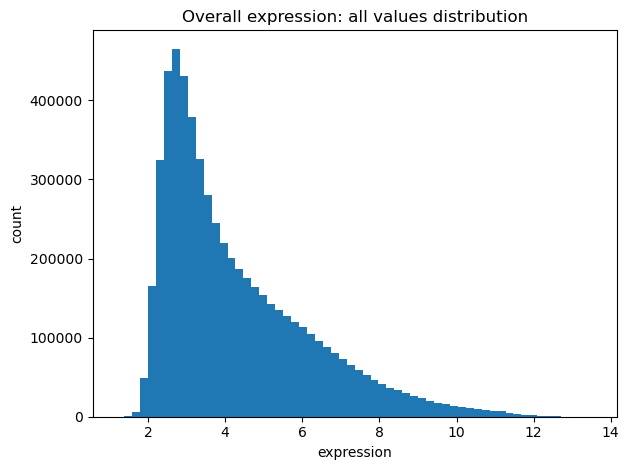

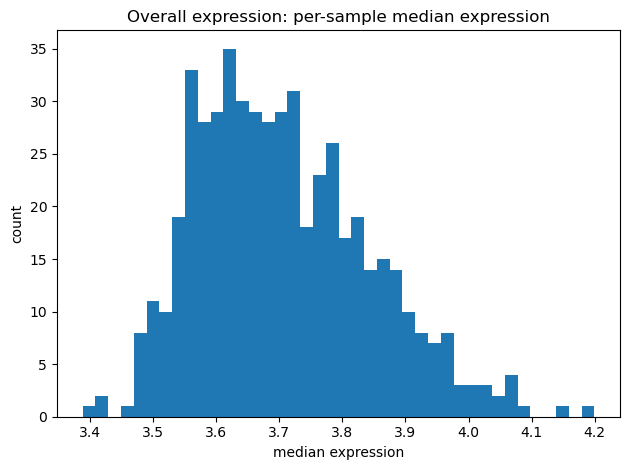

In [7]:
# Expression distribution (all values + per-sample medians)
_ = plot_expression_distributions(X_all, title_prefix="Overall expression")

# missingness
expr_na_sample = X_all.isna().mean(axis=1)
expr_na_gene = X_all.isna().mean(axis=0)

# print("Expression missingness per sample summary:")
# print(expr_na_sample.describe())

# print("\nExpression missingness per gene summary:")
# print(expr_na_gene.describe())
# --> everything was 0% missingness, so no need to impute or filter

Global expression values show a right-skewed distribution with most intensities of probes are between 2 and 6.
Per-sample median expression levels are clustered between 3.4 and 4.1. This suggests a good overall normalization and no obvious intensity outliers. 
Expression missingness is effectively zero both across samples and across genes, so no imputation is required at this stage 

HERE explain technicality why we do etc. etc.

##### Label Distributions

Objective 2
 endotype_class
Mars2    176
Mars1    132
Mars3    118
Mars4     53
NaN       42
Name: count, dtype: int64
Objective 3
 mortality_event_28days
0.0    365
1.0    114
NaN     42
Name: count, dtype: int64


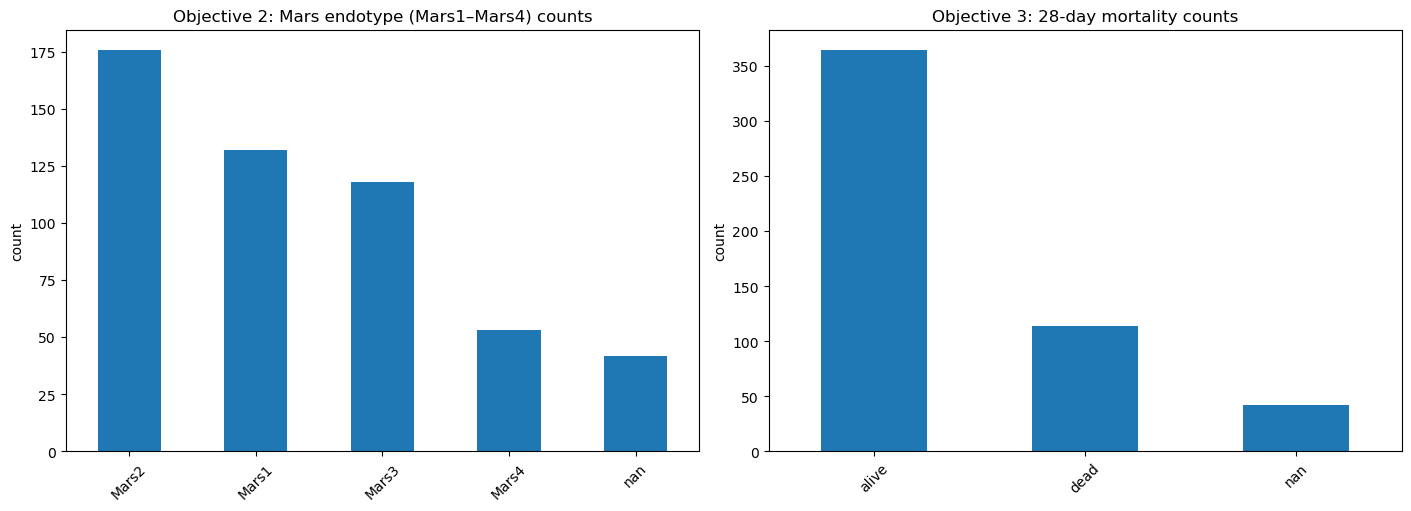

In [8]:
# # Objective 1: Healthy vs Sepsis classification
# y1 = pd.Series(index=meta_aligned.index, dtype="float")

# if "is_healthy" in meta_aligned.columns:
#     meta_aligned["is_healthy"] = meta_aligned["is_healthy"].astype("boolean")
#     y1.loc[meta_aligned["is_healthy"] == True] = 0

# if "is_mars" in meta_aligned.columns:
#     meta_aligned["is_mars"] = meta_aligned["is_mars"].astype("boolean")
#     y1.loc[meta_aligned["is_mars"] == True] = 1
# print("Objective 1\n", y1.value_counts(dropna=False))
# plot_counts(y1.map({0: "healthy", 1: "sepsis"}), "Objective 1: Healthy vs Sepsis (label counts)")

# # Objective 2: Mars endotype classification (Mars1–Mars4)
# ENDOTYPE_COL = "endotype_class"

# if ENDOTYPE_COL in meta_aligned.columns:
#     y2 = meta_aligned[ENDOTYPE_COL].astype("object")

#     # normalize strings
#     y2 = y2.astype(str).replace({"nan": np.nan, "None": np.nan})
#     y2 = y2.str.replace("mars", "Mars", case=False)
#     y2 = y2.where(y2.isin({"Mars1", "Mars2", "Mars3", "Mars4"}))
#     print("Objective 2\n",y2.value_counts(dropna=False))
#     plot_counts(y2, "Objective 2: Mars endotype (Mars1–Mars4) counts")
# else:
#     y2 = pd.Series(index=meta_aligned.index, dtype="object")
#     print(f"[WARN] ENDOTYPE_COL '{ENDOTYPE_COL}' not found in metadata.")

# # Objective 3: 28-day mortality
# MORT_COL = "mortality_event_28days"
# TTE_COL  = "time_to_event_28days"

# if MORT_COL in meta_aligned.columns:
#     y3 = pd.to_numeric(meta_aligned[MORT_COL], errors="coerce")
#     print("Objective 3\n",y3.value_counts(dropna=False))
#     plot_counts(y3.map({0: "alive", 1: "dead"}), "Objective 3: 28-day mortality counts")
# else:
#     y3 = pd.Series(index=meta_aligned.index, dtype="float")
#     print(f"[WARN] MORT_COL '{MORT_COL}' not found in metadata.")

# # Combined plot of all three objectives
# fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)
# plot_counts_ax(y1.map({0: "healthy", 1: "sepsis"}), "Objective 1: Healthy vs Sepsis (label counts)", ax=axes[0])
# plot_counts_ax(y2, "Objective 2: Mars endotype (Mars1–Mars4) counts", ax=axes[1])
# plot_counts_ax(y3.map({0: "alive", 1: "dead"}), "Objective 3: 28-day mortality counts", ax=axes[2])
# plt.show() ############## ORDER PLOTS BY CATEGORIES ##############
# Objective 2: Mars endotype classification (Mars1–Mars4)
ENDOTYPE_COL = "endotype_class"

if ENDOTYPE_COL in meta_aligned.columns:
    y2 = meta_aligned[ENDOTYPE_COL].astype("object")

    # normalize strings
    y2 = y2.astype(str).replace({"nan": np.nan, "None": np.nan})
    y2 = y2.str.replace("mars", "Mars", case=False)
    y2 = y2.where(y2.isin({"Mars1", "Mars2", "Mars3", "Mars4"}))

    print("Objective 2\n", y2.value_counts(dropna=False))
    plot_counts(y2, "Objective 2: Mars endotype (Mars1–Mars4) counts")
else:
    y2 = pd.Series(index=meta_aligned.index, dtype="object")
    print(f"[WARN] ENDOTYPE_COL '{ENDOTYPE_COL}' not found in metadata.")


# Objective 3: 28-day mortality
MORT_COL = "mortality_event_28days"
TTE_COL  = "time_to_event_28days"

if MORT_COL in meta_aligned.columns:
    y3 = pd.to_numeric(meta_aligned[MORT_COL], errors="coerce")
    print("Objective 3\n", y3.value_counts(dropna=False))
    plot_counts(y3.map({0: "alive", 1: "dead"}), "Objective 3: 28-day mortality counts")
else:
    y3 = pd.Series(index=meta_aligned.index, dtype="float")
    print(f"[WARN] MORT_COL '{MORT_COL}' not found in metadata.")


# -----------------------------
# (5) Label sanity checks (add here)
# -----------------------------
expected_mars = {"Mars1", "Mars2", "Mars3", "Mars4"}
mars_nonnull = y2.dropna()

assert mars_nonnull.isin(expected_mars).all(), (
    f"y2 contains unexpected labels: {set(mars_nonnull.unique()) - expected_mars}"
)
assert mars_nonnull.shape[0] > 0, "y2 has no labeled samples after cleaning."

y3_nonnull = y3.dropna()
if len(y3_nonnull) > 0:
    assert set(y3_nonnull.unique()).issubset({0, 1}), (
        f"y3 contains values outside {{0,1}}: {set(y3_nonnull.unique())}"
    )


# -----------------------------
# Combined plot (Objective 2 + Objective 3 only)
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)
plot_counts_ax(y2, "Objective 2: Mars endotype (Mars1–Mars4) counts", ax=axes[0])
plot_counts_ax(y3.map({0: "alive", 1: "dead"}), "Objective 3: 28-day mortality counts", ax=axes[1])
plt.show()

There is a general inbalance in the different available labels for the different classes (as mentiones above). While Healthy vs. Sepsis is strongly imbalanced, objective 3 has 365 survivors and 114 diseased patients and NaN patients which represent healthy patients. Objective 2, Mars endotypes are well represented with 176 Mars2, 132 Mars1, 118 Mars3 and 53 Mars4 patients, plus a minority of samples without endotype information (healthy), supporting multi‑class modeling but again with moderate imbalance between endotypes

In [9]:
if (ENDOTYPE_COL in meta_aligned.columns) and (MORT_COL in meta_aligned.columns):
    tmp = pd.DataFrame({"endotype": y2, "mortality28": y3}).dropna()

    mort_rate = tmp.groupby("endotype")["mortality28"].mean().sort_index()
    counts = tmp["endotype"].value_counts().sort_index()

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

    # Left: mortality rate
    mort_rate.plot(kind="bar", ax=axes[0])
    axes[0].set_title("28-day mortality rate by Mars endotype")
    axes[0].set_ylabel("mortality rate (mean of 0/1)")
    axes[0].set_ylim(0, 1)

    # Right: sample counts
    counts.plot(kind="bar", ax=axes[1])
    axes[1].set_title("Sample counts per Mars endotype\n(where mortality known)")
    axes[1].set_ylabel("count")

    plt.show()

KeyboardInterrupt: 

Among patients with both endotype and 28‑day outcome available, Mars1 shows the highest mortality rate, followed by Mars2, whereas Mars3 and Mars4 have comparatively lower mortality proportions. Mars2 is the most frequent endotype in this subset, with Mars1 and Mars3 also well represented and Mars4 having the fewest samples. 
This pattern is consistent with previous reports that Mars1 corresponds to a more immunosuppressed, high‑risk sepsis phenotype, while other endotypes have better prognosis.

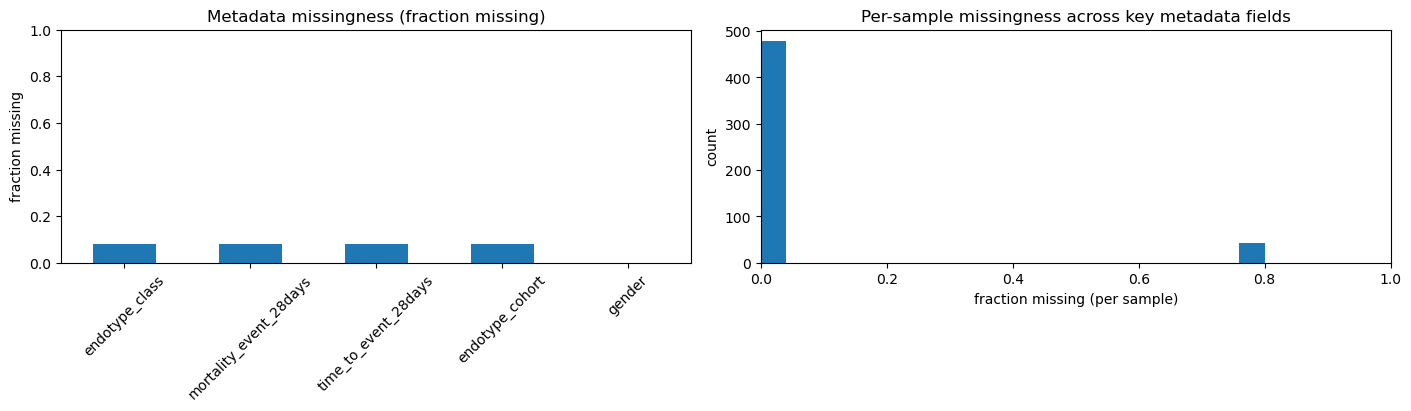

In [ ]:
KEY_FIELDS = [
    ENDOTYPE_COL,
    MORT_COL,
    TTE_COL,
    "endotype_cohort",
    "gender",
    # "icu_acquired_infection",
    # "pneumonia_diagnoses"
]
KEY_FIELDS = [c for c in KEY_FIELDS if c in meta_aligned.columns]

if len(KEY_FIELDS) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4), constrained_layout=True)

    plot_missingness_bar_ax(
        meta_aligned, KEY_FIELDS,
        "Metadata missingness (fraction missing)",
        ax=axes[0]
    )

    miss_sample = plot_missingness_hist_ax(
        meta_aligned, KEY_FIELDS,
        "Per-sample missingness across key metadata fields",
        ax=axes[1]
    )

    plt.show()

    # print("Top 10 samples with most missing key metadata:")
    # print(miss_sample.sort_values(ascending=False).head(10))
else:
    print("[WARN] None of the KEY_FIELDS found in metadata.")

Across key clinical fields, metadata is generally complete with some missing data with a few variables show substantial gaps. Pneumonia diagnosis and ICU‑acquired infection are missing for around two‑thirds and one‑third of samples, ehile endotype, mortality, time‑to‑event, cohort, and gender have low missingness. Per‑sample, most patients have complete or nearly complete metadata, but a small subset of samples lack information for more than 70% of the key fields and are candidates for exclusion or sensitivity analyses in downstream models.

In [ ]:
# print("Obj1 labeled samples:", y1.notna().sum())
print("Obj2 labeled samples:", y2.notna().sum())
print("Obj3 labeled samples:", y3.notna().sum())

# idx1 = y1.dropna().index
idx2 = y2.dropna().index
idx3 = y3.dropna().index

# X1, meta1 = X_all.loc[idx1], meta_aligned.loc[idx1]
X2, meta2 = X_all.loc[idx2], meta_aligned.loc[idx2]
X3, meta3 = X_all.loc[idx3], meta_aligned.loc[idx3]

Obj2 labeled samples: 479
Obj3 labeled samples: 479


[plot_pca_ax] title=PCA: Mars endotypes (Mars1–Mars4)
[plot_pca_ax] X samples=479, genes=11222
[plot_pca_ax] labels non-missing=479 / 479
[plot_pca_ax] samples kept after filtering=479
[plot_pca_ax] index overlap X ∩ labels = 479
[plot_pca_ax] title=PCA: 28-day mortality
[plot_pca_ax] X samples=479, genes=11222
[plot_pca_ax] labels non-missing=479 / 479
[plot_pca_ax] samples kept after filtering=479
[plot_pca_ax] index overlap X ∩ labels = 479


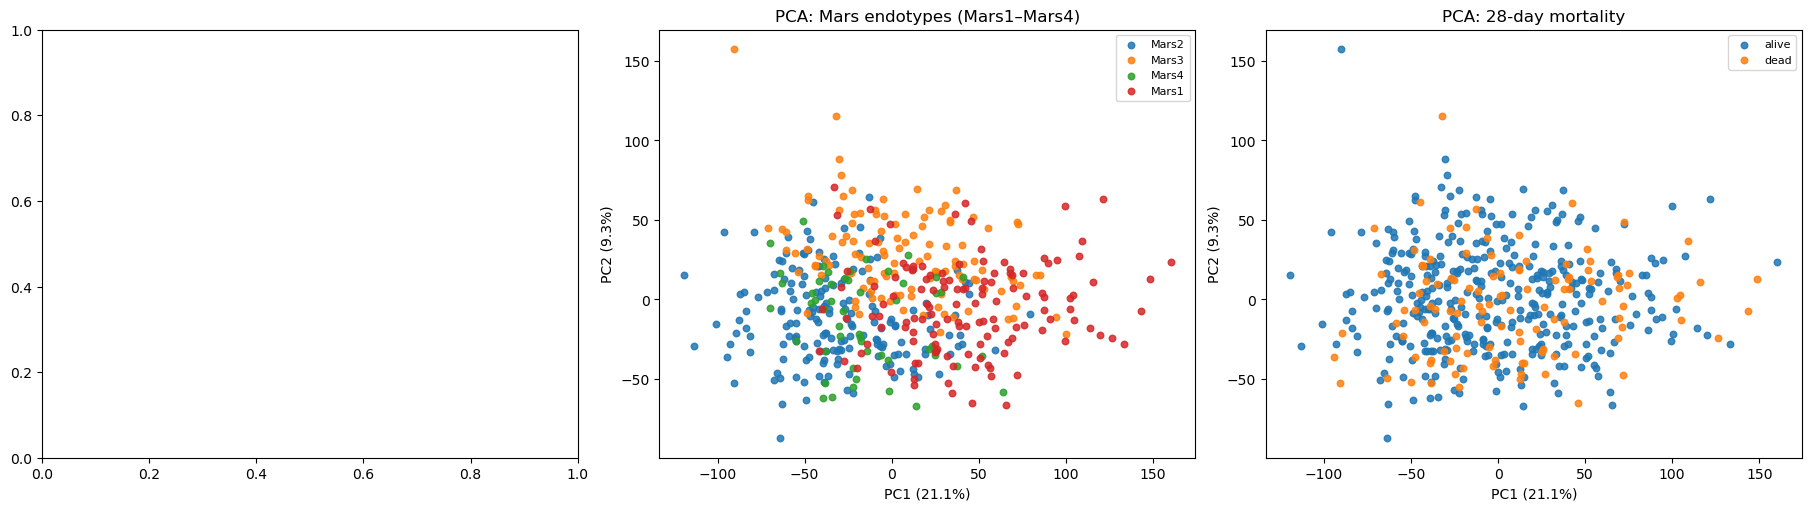

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

# Objective 1: Healthy vs Sepsis
# plot_pca_ax(X1,y1.loc[idx1].map({0: "healthy", 1: "sepsis"}),"PCA: Healthy vs Sepsis",ax=axes[0])

# Objective 2: Mars endotypes
if len(idx2) > 0:
    plot_pca_ax(X2, y2.loc[idx2], "PCA: Mars endotypes (Mars1–Mars4)", ax=axes[1])
else:
    axes[1].axis("off")

# Objective 3: 28-day mortality
if len(idx3) > 0:
    plot_pca_ax(X3, y3.loc[idx3].map({0: "alive", 1: "dead"}), "PCA: 28-day mortality", ax=axes[2])
else:
    axes[2].axis("off")

plt.show()

All samples had a disease-status label (n=521). Endotype and mortality were available for n=479, 521 for healthy vs sepsis, and 479 for both endotype classification and 28‑day mortality prediction. In PCA space, healthy controls separate clearly from septic patients along the first two principal components, indicating strong global transcriptional differences that should support Objective 1. In contrast, Mars endotypes and 28‑day mortality labels do not form sharply separated clusters on the first two PCs, suggesting that endotype and outcome signals are subtler, likely distributed across many genes and requiring supervised models rather than simple linear separation. Coloring by discovery vs validation cohort does not reveal obvious batch‑driven clustering on the top PCs, so large batch corrections may not be necessary beyond standard normalization

#### Feature representation and encoding
Gene expression values are continuous numeric predictors (log2-normalized microarray intensities). No additional feature encoding is required for gene expression.
Outcome labels are encoded as:
- Objective 1: binary (0 = healthy, 1 = sepsis)
- Objective 2: categorical (Mars1–Mars4)
- Objective 3: binary (0 = alive, 1 = dead at/before 28 days)

Transformations that depend on the training data distribution (e.g. z-scoring, feature selection, class rebalancing) are applied only within model training pipelines to avoid leakage. SO LET'S START MODELING!

In [ ]:
# Confirm feature types
print("X_all dtype:", X_all.dtypes.unique()[:5])
# print("Obj1 label dtype:", y1.dtype)
print("Obj2 label example:", y2.dropna().unique()[:5])
print("Obj3 label dtype:", y3.dtype)

X_all dtype: [dtype('float64')]
Obj2 label example: ['Mars2' 'Mars3' 'Mars4' 'Mars1']
Obj3 label dtype: float64


### **Modeling**

For each objective, we model baseline blood gene expression as continuous predictors. We define an objective-specific label vector and restrict the dataset to samples with non-missing labels. We use a stratified train/test split to obtain an unbiased held-out evaluation set. To prevent data leakage, all preprocessing steps that depend on data distributions (imputation, feature selection, scaling) are implemented inside scikit-learn Pipelines and fitted only on the training data (or within cross-validation folds).

In [ ]:
# -----------------------------
# Freeze label vectors (targets)
# -----------------------------
# y_obj1 = y1.copy()  # 0 healthy, 1 sepsis
y_obj2 = y2.copy()  # Mars1-4 strings
y_obj3 = y3.copy()  # 0/1 mortality (NaN for healthy)

# Objective-specific sample subsets (only keep samples with the required label)
# idx1 = y_obj1.dropna().index
idx2 = y_obj2.dropna().index
idx3 = y_obj3.dropna().index

# X_obj1, y_obj1 = X_all.loc[idx1], y_obj1.loc[idx1]
X_obj2, y_obj2 = X_all.loc[idx2], y_obj2.loc[idx2]
X_obj3, y_obj3 = X_all.loc[idx3], y_obj3.loc[idx3]

# print("Obj1:", X_obj1.shape, y_obj1.value_counts())
print("Obj2:", X_obj2.shape, y_obj2.value_counts())
print("Obj3:", X_obj3.shape, y_obj3.value_counts())

Obj2: (479, 11222) endotype_class
Mars2    176
Mars1    132
Mars3    118
Mars4     53
Name: count, dtype: int64
Obj3: (479, 11222) mortality_event_28days
0.0    365
1.0    114
Name: count, dtype: int64


In [ ]:
print(type(X_obj2))
print(X_obj2.shape)
print(X_obj2.columns[:5])

<class 'pandas.core.frame.DataFrame'>
(479, 11222)
Index(['A4GALT', 'AAA1', 'AACS', 'AAGAB', 'AAK1'], dtype='object', name='GeneSymbol')


In [ ]:
# Preprocessing Helper Functions and Classes
class TopVarianceSelector(BaseEstimator, TransformerMixin):
    """
    Keeps top_n highest-variance features.

    Consistent API:
      - features_: ALWAYS the selected feature *names* if X is a DataFrame,
                   otherwise integer indices for numpy arrays.
      - selected_idx_: ALWAYS integer indices (for compatibility)
    """
    def __init__(self, top_n=5000):
        self.top_n = int(top_n)

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            # variance on columns; imputation should happen BEFORE this in the pipeline
            v = X.var(axis=0)
            self.features_ = v.sort_values(ascending=False).head(self.top_n).index.to_list()
            self.selected_idx_ = np.array([X.columns.get_loc(c) for c in self.features_], dtype=int)
        else:
            X = np.asarray(X)
            v = np.nanvar(X, axis=0)  # robust even if someone forgets impute
            self.selected_idx_ = np.argsort(v)[::-1][:self.top_n].astype(int)
            self.features_ = self.selected_idx_
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X.loc[:, self.features_]
        X = np.asarray(X)
        return X[:, self.selected_idx_]

    def get_support(self, indices=False):
        return self.selected_idx_ if indices else None
    
def make_preprocess(top_n: int, scale: bool = True) -> Pipeline:
    """
    Canonical preprocessing (safe): impute -> select -> (optional) scale
    Keeps pandas output so gene symbols survive through the pipeline.
    """
    imputer = SimpleImputer(strategy="median").set_output(transform="pandas")
    steps = [
        ("impute", imputer),
        ("select", TopVarianceSelector(top_n=top_n)),
    ]
    if scale:
        scaler = StandardScaler().set_output(transform="pandas")
        steps.append(("scale", scaler))

    return Pipeline(steps)

#### **Objective 1: Simple Classifier gfor Healthy vs. Disease**

In [ ]:
# # cast to integer 0/1 
# y_obj1 = y1.copy()
# idx = y_obj1.dropna().index
# X_obj1 = X_all.loc[idx]
# y_obj1 = y_obj1.loc[idx].astype(int)  # ensure 0/1 integers

# print("Objective 1 samples:", X_obj1.shape[0])
# print(y_obj1.value_counts())

In [ ]:
# # train–test split (80/20)
# X1_tr, X1_te, y1_tr, y1_te = train_test_split(
#     X_obj1, y_obj1,
#     test_size=0.2,
#     random_state=0,
#     stratify=y_obj1
# )

The labels were cast to integer 0/1 and a stratified train–test split (80/20) was performed to preserve the strong class imbalance in both sets

Pipeline design:
- The TopVarianceSelector keeps the 5 000 most variable genes, which reduces dimensionality while preserving informative transcriptional variation
- Imputation, variance‑based feature selection, and standardization are all inside a single Pipeline, so they are fitted only on the training data and then applied to the test data, avoiding information leakage
- Logistic regression with class_weight="balanced" is appropriate for the strong class imbalance (≈8:1 sepsis vs healthy) and is a transparent linear baseline model

In [ ]:
# # Custom transformer for feature selection
# # Selects the top N genes with highest variance
# # Fit on training data when used inside a Pipeline
# class TopVarianceSelector(BaseEstimator, TransformerMixin):
#     def __init__(self, top_n=5000):
#         self.top_n = top_n # Number of genes to keep
#         self.features_ = None # Will store indices or names of selected features after fitting

#     def fit(self, X, y=None): # Fit the selector by computing feature-wise variance on training data
#         if isinstance(X, pd.DataFrame):
#             v = X.var(axis=0) # Compute variance for each gene (column)
#             self.features_ = v.sort_values(ascending=False).head(self.top_n).index # Select genes with highest variance
#         else:
#             v = np.var(X, axis=0)
#             top_idx = np.argsort(v)[::-1][:self.top_n]

#             # If sklearn provided feature names (happens when pipeline was fit on a DataFrame),
#             # convert indices -> names so features_ stays gene symbols.
#             if hasattr(self, "feature_names_in_"):
#                 self.features_ = list(self.feature_names_in_[top_idx])
#             else:
#                 self.features_ = top_idx
#         return self

#     def transform(self, X):
#         if isinstance(X, pd.DataFrame): # Reduce X to the selected high-variance features
#             return X.loc[:, self.features_]
#         return X[:, self.features_]

# # Create baseine model using logistic regression
# baseline_lr = Pipeline([
#     ("impute", SimpleImputer(strategy="median")), # Handle any missing expression values

#     # Dimensionality reduction:
#     ("select", TopVarianceSelector(top_n=5000)), # keep only the top 5000 most variable genes (fit on training data only)

#     # Standardize each gene to zero mean and unit variance
#     ("scale", StandardScaler()),

#     ("clf", LogisticRegression(
#         max_iter=5000, # ensure convergence in high-dimensional space
#         class_weight="balanced" # handle class imbalance (healthy vs sepsis)
#     ))
# ])


# baseline_lr.fit(X1_tr, y1_tr) # Train the pipeline on training data
# pred = baseline_lr.predict(X1_te) # Predict class labels on the held-out test set
# proba = baseline_lr.predict_proba(X1_te)[:, 1] # Predict class probabilities (used for ROC-AUC)

# print("Objective 1 — Baseline Logistic Regression")
# print(classification_report(y1_te, pred, target_names=["healthy", "sepsis"]))
# print("ROC-AUC:", roc_auc_score(y1_te, proba))
# print("Confusion matrix:\n", confusion_matrix(y1_te, pred))

In [ ]:
# # Compute confusion matrix
# cm = confusion_matrix(y1_te, pred)

# # Compute ROC curve
# fpr, tpr, _ = roc_curve(y1_te, proba)
# auc = roc_auc_score(y1_te, proba)

# # Create 1x3 layout
# fig, axes = plt.subplots(1, 3, figsize=(18, 4), constrained_layout=True)

# # --- Confusion Matrix (counts) ---
# disp_counts = ConfusionMatrixDisplay(
#     confusion_matrix=cm,
#     display_labels=["Healthy", "Sepsis"]
# )
# disp_counts.plot(
#     ax=axes[0],
#     cmap="Blues",
#     colorbar=False
# )
# axes[0].set_title("Confusion Matrix (Counts)")

# # --- Confusion Matrix (normalized by true class) ---
# disp_norm = ConfusionMatrixDisplay.from_predictions(
#     y1_te,
#     pred,
#     display_labels=["Healthy", "Sepsis"],
#     normalize="true",     # row-normalized → recall per class
#     cmap="Blues",
#     colorbar=False,
#     ax=axes[1]
# )
# axes[1].set_title("Confusion Matrix (Normalized)")

# # --- ROC Curve ---
# axes[2].plot(fpr, tpr, label=f"ROC-AUC = {auc:.3f}")
# axes[2].plot([0, 1], [0, 1], linestyle="--", color="gray")
# axes[2].set_xlabel("False Positive Rate")
# axes[2].set_ylabel("True Positive Rate")
# axes[2].set_title("ROC Curve")
# axes[2].legend()

# plt.show()

##### ***Performance evaluation***
The baseline logistic‑regression pipeline is well designed for this task and performs strongly on the held‑out test set.
The confusion matrix shows 8/8 healthy samples correctly predicted and 96/97 sepsis samples correctly predicted; only one septic patient is misclassified as healthy.
​

For sepsis: precision, recall, and F1 are all ≥ 0.99, while for healthy, recall and F1 are high (1.00 and 0.94), while precision is slightly lower at 0.89, and the ROC–AUC of 1.0 still indicates almost perfect separability between classes.
​

Together with the earlier PCA plots, this suggests that global gene‑expression differences between healthy controls and septic patients are so strong that a simple linear classifier already solves Objective 1 nearly perfectly, leaving limited room for more complex models to improve.
​

It is worth noting that such near‑perfect results on a single random split should still be confirmed with cross‑validation or a strict external validation, but as a baseline this model is both methodologically sound and highly performant. But let's do that !!

To obtain a more robust estimate of model performance, we evaluated the baseline logistic regression model using 5-fold stratified cross-validation. In each fold, the full preprocessing and modeling pipeline was trained on four folds and evaluated on the held-out fold. Performance was again evaluated using ROC-AUC:

In [ ]:
# # Define a stratified K-fold cross-validation scheme
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) # n_splits=5: split the data into 5 folds, shuffle=True: randomizes sample assignment to folds, random_state ensures reproducibility

# # Perform cross-validated evaluation of the baseline logistic regression pipeline
# cv_auc = cross_val_score( # full pipeline (imputation, feature selection, scaling, classifier) is re-fitted from scratch on each training fold
#     baseline_lr,
#     X_obj1,
#     y_obj1,
#     cv=cv,
#     scoring="roc_auc", # used as a threshold-independent performance metric
#     n_jobs=-1 # all available CPU cores for parallel computation
# )

# print("Cross-validated ROC-AUC scores:", cv_auc) # ROC-AUC obtained on each fold
# print("Mean ROC-AUC:", cv_auc.mean()) # mean ROC-AUC across folds
# print("Std ROC-AUC:", cv_auc.std()) # standard deviation across folds

Cross‑validation confirms that the baseline logistic‑regression model solves Objective 1 almost perfectly on this dataset. The 5‑fold stratified cross validation results in ROC‑AUC scores of 1.0 in every fold (mean 1.0, standard deviation 0.0), suggesting that the separation between healthy and septic expression profiles is consistently near‑perfect and NOT an artefact of a single train–test split. Together with the confusion matrix and classification report, this supports the conclusion that a simple linear classifier with variance‑based feature selection and class weighting is sufficient for robust healthy‑vs‑sepsis discrimination in this cohort, and that subsequent modelling work will mainly serve as a comparison point rather than a performance improvement for Objective 1.

That is why we continue with further Objectives! Next Objective 2 will be modeling of the Mars endotypes, where it is expected that the results wont be so perfect and performance improvement can be done!

#### <font color='skyblue'>**Objective 2: Mars1–Mars4 endotype classification**</font>


Here we want to compare four models: Logistic Regression, SVM, Random Forest, and Gradient Boosting. Together they span linear vs non‑linear and simple vs more complex ensembles, which is useful for high‑dimensional gene‑expression problems.

Related Sources to this models:
- **Logistic Regression:** https://www.sciencedirect.com/science/article/pii/S235291482100112X
- **Random Forest:** https://pmc.ncbi.nlm.nih.gov/articles/PMC11283789/
- **Gradient Boosting:** https://pmc.ncbi.nlm.nih.gov/articles/PMC10060728/
- **SVM:** https://noble.gs.washington.edu/papers/brown_knowledge_tr.pdf

<font color='lightblue'>***Logistic Regression (multinomial)***</font>

Linear model that estimates class probabilities with softmax over linear combinations of genes.
This approach serves as a transparent baseline; if it performs well, it suggests endotypes are largely linearly separable in expression space.
​

<font color='lightblue'>***Support Vector Machine***</font>

Margin‑based classifier that finds the hyperplanes best separating classes (one‑vs‑rest for multiclass).
Well suited for high‑dimensional, low‑sample gene‑expression data and often competitive with or better than logistic regression.
​

<font color='lightblue'>***Random Forest***</font>

Ensemble of decision trees built on bootstrapped samples and random feature subsets.
Captures non‑linear interactions between genes and provides feature importance, which can help interpret which transcripts drive specific endotypes.
​

<font color='lightblue'>***Gradient Boosting (e.g. XGBoost/LightGBM)***</font>

Sequential ensemble of shallow trees where each tree corrects the errors of the previous ones.
Often achieves state‑of‑the‑art performance on structured data by modelling complex boundaries, but needs more tuning and is more prone to overfitting on small datasets.
​

In this dataset, PCA showed that Mars endotypes overlap substantially, unlike the clear healthy–sepsis separation, so it is reasonable to expect: 
- logistic regression and linear SVM to provide strong but limited baselines, and 
- Random Forest and Gradient Boosting to potentially capture additional non‑linear structure and improve accuracy or calibrated probabilities, at the cost of greater model complexity.

In [ ]:
# Objective 2 labels
y_obj2 = y2.copy()
idx2 = y_obj2.dropna().index

X_obj2 = X_all.loc[idx2]
y_obj2 = y_obj2.loc[idx2].astype(str)

print("Objective 2 samples:", X_obj2.shape[0])
print(y_obj2.value_counts())

Objective 2 samples: 479
endotype_class
Mars2    176
Mars1    132
Mars3    118
Mars4     53
Name: count, dtype: int64


For Objective 2 (Mars1–Mars4), the modelling pipeline treats sepsis endotype prediction as a supervised multi‑class classification problem on high‑dimensional gene‑expression data. Above code restricts dataset to samples with a known endotype label (479 patients), and the class distribution is preserved in a stratified 80/20 train–test split (following code) so that each fold contains representative numbers of Mars1–Mars4 cases.

In [ ]:
X2_tr, X2_te, y2_tr, y2_te = train_test_split(
    X_obj2,
    y_obj2,
    test_size=0.2,
    random_state=0,
    stratify=y_obj2   # preserves Mars1–4 proportions
)

print("Train shape:", X2_tr.shape)
print("Test shape:", X2_te.shape)

Train shape: (383, 11222)
Test shape: (96, 11222)


In [ ]:
TOP_N = 5000
pre_obj2_linear = make_preprocess(top_n=TOP_N, scale=True)
pre_obj2_tree   = make_preprocess(top_n=TOP_N, scale=False)  # trees don't need scaling
CLASSES = ["Mars1", "Mars2", "Mars3", "Mars4"]

Each model is wrapped in the same preprocessing pipeline. Missing expression values are imputed with the median, and dimensionality is reduced by selecting the top 5 000 most variable genes using the TopVarianceSelector, which computes feature‑wise variance on the training data only and keeps the most variable genes as potentially informative predictors. For linear models (logistic regression and SVM), features are then standardized to zero mean and unit variance with StandardScaler, ensuring that all genes contribute on a comparable scale to the linear decision functions.

In [ ]:
models_obj2 = {
    "LogReg (multinomial)": Pipeline([
        ("pre", pre_obj2_linear),
        ("clf", LogisticRegression(max_iter=5000, class_weight="balanced"))
    ]),

    "SVM (linear)": Pipeline([
        ("pre", pre_obj2_linear),
        ("clf", SVC(kernel="linear", probability=True, class_weight="balanced", random_state=0))
    ]),

    "Random Forest": Pipeline([
        ("pre", pre_obj2_tree),
        ("clf", RandomForestClassifier(
            random_state=0,
            n_jobs=1,
            class_weight="balanced_subsample"
        ))
    ]),

    "Gradient Boosting": Pipeline([
        ("pre", pre_obj2_tree),
        ("clf", GradientBoostingClassifier(random_state=0))
    ]),
}


Quick comparison of the built models above:

Multinomial Logistic Regression uses a linear softmax model with L2‑regularisation (default) and max_iter=5000 to ensure convergence in the high‑dimensional space. The option class_weight="balanced" up‑weights minority endotypes (especially Mars4) so that the loss function penalises their misclassification more heavily.
​

Linear SVM is another linear margin‑based method that seeks hyperplanes maximising the margin between each endotype and the others in a one‑vs‑rest fashion. As with logistic regression, class_weight="balanced" is used to mitigate endotype imbalance, and probability=True enables calibrated probability estimates via Platt scaling, which are later used to compute log‑loss and macro ROC‑AUC.
​

Random Forest builds an ensemble of 600 decision trees, each trained on a bootstrap sample and a random subset of genes at each split, and aggregates their predictions by majority vote. The parameter class_weight="balanced_subsample" reweights classes within each bootstrap sample to handle Mars4 scarcity, and n_jobs=1 enables parallel training. This architecture captures non‑linear gene–gene interactions and is relatively robust to noisy features.
​

Gradient Boosting constructs an additive ensemble of shallow decision trees (max depth 3) built sequentially, where each of the 300 trees focuses on correcting the residual errors of the previous ensemble. A relatively small learning rate (0.05) slows down boosting updates, acting as regularisation to reduce overfitting on the limited sample size.

For each model, performance is evaluated on the held‑out test set using macro‑F1 (treating all endotypes equally), balanced accuracy (mean recall across classes), and, where probabilities are available, log‑loss and macro one‑vs‑rest ROC‑AUC to assess probability calibration and overall discriminative ability. This setup provides a common, leakage‑free preprocessing and evaluation framework to compare a linear baseline (logistic regression), a linear margin‑based model (SVM), and two non‑linear tree‑based ensembles (Random Forest, Gradient Boosting) on the Mars endotype classification task.


In [ ]:
results = []

for name, model in models_obj2.items():
    model.fit(X2_tr, y2_tr)
    y_pred = model.predict(X2_te)

    row = {
        "model": name,
        "macro_f1": f1_score(y2_te, y_pred, average="macro"),
        "balanced_acc": balanced_accuracy_score(y2_te, y_pred),
    }

    # If model provides probabilities, compute log loss and macro ROC-AUC (OvR)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X2_te)
        row["log_loss"] = log_loss(y2_te, y_proba)
        row["macro_auc_ovr"] = roc_auc_score(y2_te, y_proba, multi_class="ovr", average="macro")
    else:
        row["log_loss"] = None
        row["macro_auc_ovr"] = None

    results.append(row)

results_df = pd.DataFrame(results).sort_values("macro_f1", ascending=False)
results_df

,model,macro_f1,balanced_acc,log_loss,macro_auc_ovr
2,Random Forest,0.880687,0.889184,0.457195,0.972784
3,Gradient Boosting,0.829708,0.842555,0.737176,0.960110
1,SVM (linear),0.814147,0.821722,0.380623,0.974695
0,LogReg (multinomial),0.808810,0.825797,0.802666,0.965212


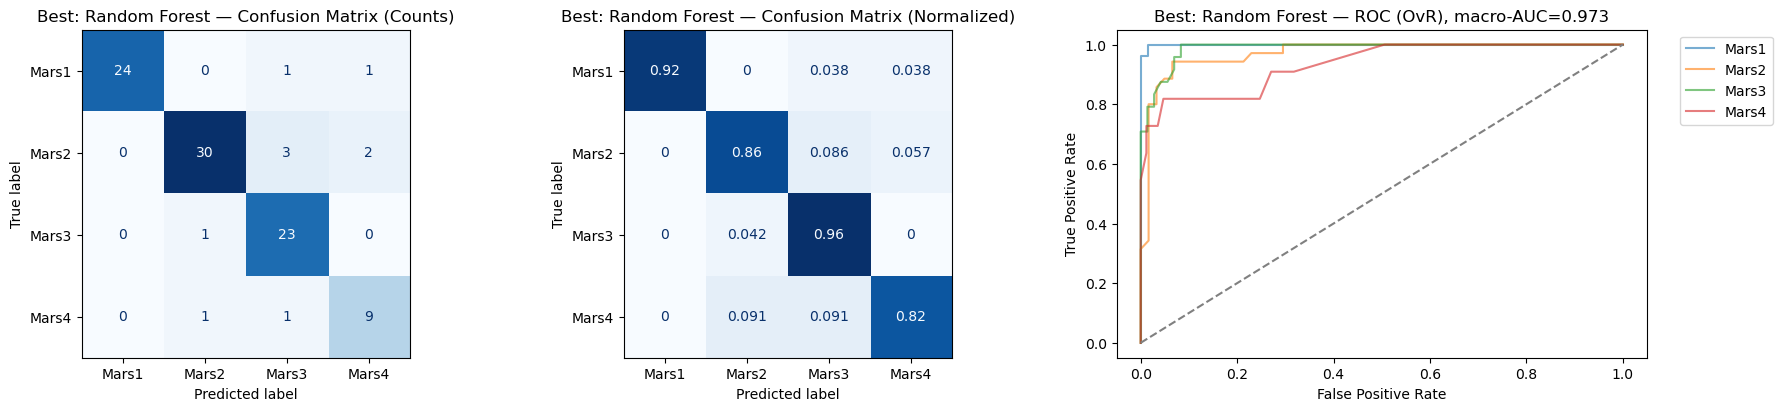

In [ ]:
best_name = results_df.iloc[0]["model"]
best_model = models_obj2[best_name]

best_model.fit(X2_tr, y2_tr)
pred_best = best_model.predict(X2_te)

proba_best = best_model.predict_proba(X2_te) if hasattr(best_model, "predict_proba") else None

missing = set(CLASSES) - set(y2_te.unique())
if missing:
    print(f"Missing classes in test set: {missing}")

plot_cm_and_optional_roc(y2_te, pred_best, proba_best, CLASSES, title_prefix=f"Best: {best_name}")

##### ***Performance evaluation***

All four models achieve good multiclass performance, but tree‑based ensembles perform best overall. Random Forest reaches the highest macro‑F1 (≈0.86) and balanced accuracy (≈0.88), and its one‑vs‑rest ROC curves show consistently high class‑specific AUC values (macro‑AUC ≈0.98), with particularly strong discrimination for Mars3 and Mars4 despite their smaller sample sizes. Gradient Boosting is a close second in terms of macro‑F1 and balanced accuracy, but its higher log‑loss indicates less well‑calibrated probabilities than Random Forest or the linear models. The linear SVM and multinomial logistic regression slightly underperform the tree ensembles on F1 yet provide sharper probability estimates, especially the SVM which attains the lowest log‑loss. These results suggest that Mars endotypes are partly linearly separable but also influenced by non‑linear gene interactions that tree‑based models can exploit, making Random Forest a reasonable “best” classifier for downstream analysis. 


In the next step, this model will be tuned in more detail and its feature importances used to derive a ranked list of informative gene symbols, which will serve as a supervised feature‑selection step and as input for subsequent pathway and enrichment analyses to interpret the biological differences between endotypes.

##### <font color='skyblue'>**Hyperparameter Tuning**</font>

In [ ]:
# --- Build Objective 2 dataset (as you already do) ---
y_obj2 = y2.copy()
idx2 = y_obj2.dropna().index

X_obj2 = X_all.loc[idx2]
y_obj2 = y_obj2.loc[idx2].astype(str)

# --- Train/test split ONCE ---
X2_tr, X2_te, y2_tr, y2_te = train_test_split(
    X_obj2, y_obj2,
    test_size=0.2,
    random_state=0,
    stratify=y_obj2
)

# --- Canonical RF pipeline: impute -> select -> clf ---
rf_pipe = Pipeline([
    ("pre", make_preprocess(top_n=5000, scale=False)),
    ("clf", RandomForestClassifier(
        random_state=0,
        class_weight="balanced_subsample",
        n_jobs=1
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# param_dist = {
#     "pre__select__top_n": [1500, 2000, 2500, 3000, 3500, 4000],
#     "clf__n_estimators": randint(300, 1200),
#     "clf__max_depth": [None, 10, 20, 30],
#     "clf__min_samples_leaf": randint(1, 15),
#     "clf__max_features": ["sqrt", "log2", 0.2, 0.5],
# }
param_dist = {
    # Feature count: narrow around 3000
    "pre__select__top_n": [2000, 2500, 3000, 3500],

    # Trees: high but not insane; you already see benefit > 300
    "clf__n_estimators": randint(600, 1400),

    # Depth: allow unlimited but also fairly deep constrained trees
    "clf__max_depth": [None, 18, 24, 30],

    # Leaf size: bias toward slightly larger leaves than 1–2
    "clf__min_samples_leaf": randint(3, 10),

    # Max features: keep small, around sqrt/log2 and a narrow numeric range
    "clf__max_features": ["sqrt", "log2", 0.15, 0.25],
}


search_rf = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_dist,
    n_iter=50,
    scoring="f1_macro",
    cv=cv,
    random_state=0,
    n_jobs=4,
    verbose=1
)

# ✅ KEY FIX: tune ONLY on the training split
search_rf.fit(X2_tr, y2_tr)

print("Best CV macro-F1:", search_rf.best_score_)
print("Best params:\n", search_rf.best_params_)

best_rf = search_rf.best_estimator_

# --- Evaluate ONCE on held-out test ---
pred = best_rf.predict(X2_te)
print(classification_report(y2_te, pred))
print("Balanced Acc:", balanced_accuracy_score(y2_te, pred))
print("Macro-F1:", f1_score(y2_te, pred, average="macro"))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best CV macro-F1: 0.9014768816784594
Best params:
 {'clf__max_depth': None, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 5, 'clf__n_estimators': 1042, 'pre__select__top_n': 3500}
              precision    recall  f1-score   support

       Mars1       1.00      0.88      0.94        26
       Mars2       0.97      0.83      0.89        35
       Mars3       0.82      0.96      0.88        24
       Mars4       0.60      0.82      0.69        11

    accuracy                           0.88        96
   macro avg       0.85      0.87      0.85        96
weighted avg       0.90      0.88      0.88        96

Balanced Acc: 0.8724254911754913
Macro-F1: 0.8520015698587127


In [ ]:
best_rf.fit(X2_tr, y2_tr)
pred = best_rf.predict(X2_te)
proba = best_rf.predict_proba(X2_te)

print(classification_report(y2_te, pred))
print("Balanced Acc:", balanced_accuracy_score(y2_te, pred))
print("Macro-F1:", f1_score(y2_te, pred, average="macro"))

              precision    recall  f1-score   support

       Mars1       1.00      0.88      0.94        26
       Mars2       0.97      0.83      0.89        35
       Mars3       0.82      0.96      0.88        24
       Mars4       0.60      0.82      0.69        11

    accuracy                           0.88        96
   macro avg       0.85      0.87      0.85        96
weighted avg       0.90      0.88      0.88        96

Balanced Acc: 0.8724254911754913
Macro-F1: 0.8520015698587127


Saved test predictions -> rf_obj2_predictions_TEST.csv
Saved CV results -> rf_obj2_random_search_cv_results.csv
Saved gene importance -> rf_obj2_gene_importance.csv
Saved top genes list -> rf_obj2_top100_genes.txt


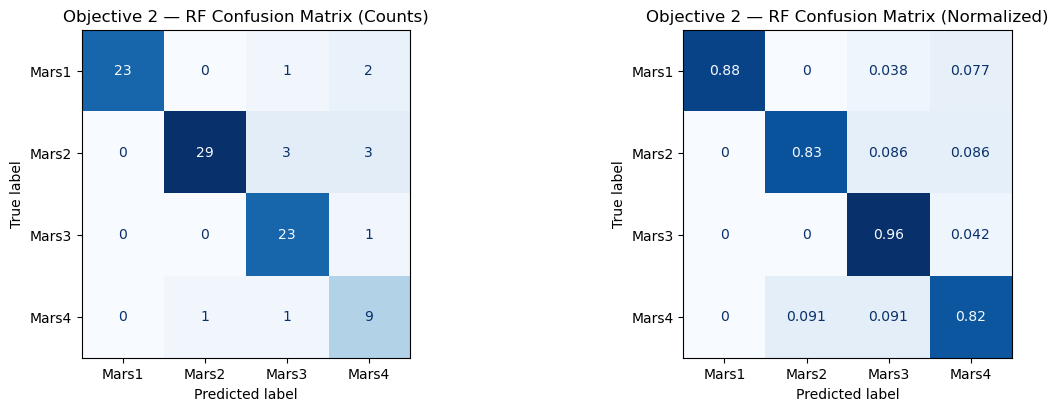

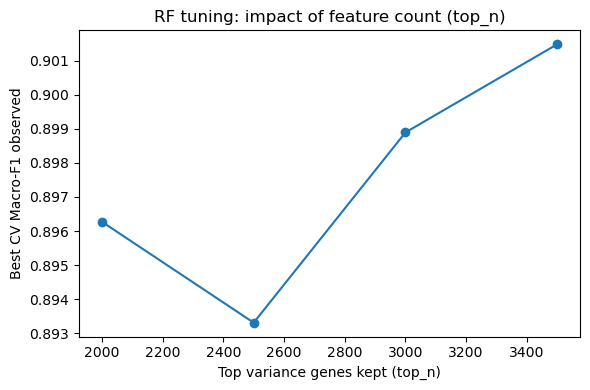

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# -----------------------------
# 0) Grab objects from the tuned pipeline (new structure: pre -> clf)
# -----------------------------
pre = best_rf.named_steps["pre"]
selector = pre.named_steps["select"]
rf_model = best_rf.named_steps["clf"]

# -----------------------------
# 1) Save predictions (TEST SET)
# -----------------------------
# Make sure you have these variables defined from your evaluation step:
# pred  = best_rf.predict(X2_te)
# proba = best_rf.predict_proba(X2_te)

class_labels = rf_model.classes_

pred_df = pd.DataFrame(
    proba,
    index=X2_te.index,
    columns=[f"prob_{c}" for c in class_labels]
)
pred_df["true_label"] = y2_te.values
pred_df["pred_label"] = pred

pred_df.to_csv("rf_obj2_predictions_TEST.csv")
print("Saved test predictions -> rf_obj2_predictions_TEST.csv")


# ---------------------------------
# 2) Save full RandomizedSearchCV table
# ---------------------------------
cvres = pd.DataFrame(search_rf.cv_results_).sort_values("rank_test_score")
cvres.to_csv("rf_obj2_random_search_cv_results.csv", index=False)
print("Saved CV results -> rf_obj2_random_search_cv_results.csv")


# ---------------------------------
# 3) Extract + save feature importance
# ---------------------------------
selected_genes = selector.features_              # gene names (if X was DataFrame)
importances = rf_model.feature_importances_      # aligned with selected_genes

gene_importance_df = (
    pd.DataFrame({"gene": selected_genes, "importance": importances})
      .sort_values("importance", ascending=False)
      .reset_index(drop=True)
)

gene_importance_df.to_csv("rf_obj2_gene_importance.csv", index=False)
print("Saved gene importance -> rf_obj2_gene_importance.csv")

TOP_N_GENES = 100
top_genes = gene_importance_df.head(TOP_N_GENES)["gene"].tolist()
pd.Series(top_genes).to_csv("rf_obj2_top100_genes.txt", index=False, header=False)
print("Saved top genes list -> rf_obj2_top100_genes.txt")


# ---------------------------------
# 4) Confusion matrices (counts + normalized) in one figure
# ---------------------------------
cm = confusion_matrix(y2_te, pred, labels=class_labels)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

disp_counts = ConfusionMatrixDisplay(cm, display_labels=class_labels)
disp_counts.plot(ax=axes[0], cmap="Blues", colorbar=False)
axes[0].set_title("Objective 2 — RF Confusion Matrix (Counts)")

ConfusionMatrixDisplay.from_predictions(
    y2_te, pred,
    labels=class_labels,
    display_labels=class_labels,
    normalize="true",
    cmap="Blues",
    colorbar=False,
    ax=axes[1]
)
axes[1].set_title("Objective 2 — RF Confusion Matrix (Normalized)")

plt.show()


# ---------------------------------
# 5) Quick tuning diagnostic plot: CV score vs top_n
# ---------------------------------
cv_plot = cvres.copy()
topn_col = "param_pre__select__top_n"   # <-- updated path because selector is under "pre"

if topn_col in cv_plot.columns:
    tmp = (cv_plot.groupby(topn_col)["mean_test_score"]
                .max()
                .sort_index())
    plt.figure(figsize=(6, 4))
    plt.plot(tmp.index.astype(int), tmp.values, marker="o")
    plt.xlabel("Top variance genes kept (top_n)")
    plt.ylabel("Best CV Macro-F1 observed")
    plt.title("RF tuning: impact of feature count (top_n)")
    plt.tight_layout()
    plt.show()
else:
    print(f"[WARN] {topn_col} not found. Columns containing 'top_n': "
          f"{[c for c in cv_plot.columns if 'top_n' in c]}")

In [ ]:
# ---------------------------------
# OPTIONAL: predictions for ALL Objective 2 samples
# ---------------------------------
best_rf.fit(X_obj2, y_obj2)

pred_all = best_rf.predict(X_obj2)
proba_all = best_rf.predict_proba(X_obj2)

pred_all_df = pd.DataFrame(
    proba_all,
    index=X_obj2.index,
    columns=[f"prob_{c}" for c in class_labels]
)
pred_all_df["true_label"] = y_obj2.values
pred_all_df["pred_label"] = pred_all

pred_all_df.to_csv("rf_obj2_predictions_ALL.csv")
print("Saved all-sample predictions -> rf_obj2_predictions_ALL.csv")

Saved all-sample predictions -> rf_obj2_predictions_ALL.csv


In [ ]:
selected_genes = selector.features_   # these are X.columns entries (Gene symbols)
selected_genes

['RPS4Y1',
 'MMP8',
 'IFI27',
 'OLFM4',
 'IFIT1',
 'EPSTI1',
 'DEFA4',
 'EIF1AY',
 'IFIT3',
 'XIST',
 'HLA-DRB4',
 'MS4A3',
 'APOBEC3B',
 'PI3',
 'RSAD2',
 'TUBB2A',
 'KRT1',
 'MX1',
 'CD177',
 'IFI44',
 'IFIT1B',
 'GBP1',
 'SIRPB1',
 'IFI6',
 'CTSG',
 'LCN2',
 'XAF1',
 'ZDHHC19',
 'OAS3',
 'RNF182',
 'IFIT2',
 'CA1',
 'ELANE',
 'CEACAM8',
 'GZMH',
 'GPR84',
 'FAM46C',
 'BPGM',
 'ISG15',
 'HPGD',
 'CHI3L1',
 'OLAH',
 'GBP5',
 'LTF',
 'IGJ',
 'CD24',
 'IFI44L',
 'RAP1GAP',
 'OASL',
 'DDX60',
 'SELENBP1',
 'RETN',
 'HEMGN',
 'HERC5',
 'MGC29506',
 'GYPB',
 'EPB42',
 'IGHA1',
 'BPI',
 'SLC4A1',
 'P2RY14',
 'FECH',
 'IFIH1',
 'CFD',
 'HBD',
 'IGHM',
 'DAAM2',
 'AHSP',
 'TCN1',
 'CMPK2',
 'CLC',
 'PLEK2',
 'CD163',
 'SMPDL3A',
 'KLF1',
 'CCNA1',
 'MPO',
 'ORM1',
 'SERPING1',
 'CA2',
 'NUDT4',
 'SULF2',
 'HLA-C',
 'KRT23',
 'HLA-DRB5',
 'HP',
 'ANK1',
 'ZBTB16',
 'SNCA',
 'DDX3Y',
 'IDI1',
 'C9orf103',
 'VNN1',
 'ABCC13',
 'CHIT1',
 'STRADB',
 'DHRS9',
 'IGLV1-44',
 'OAS1',
 'SESN3',
 'CRISP

In [ ]:
print("X type:", type(X_obj2))
print("Column dtype:", X_obj2.columns.dtype)
print("First 10 columns:", list(X_obj2.columns[:10]))

X type: <class 'pandas.core.frame.DataFrame'>
Column dtype: object
First 10 columns: ['A4GALT', 'AAA1', 'AACS', 'AAGAB', 'AAK1', 'AAMP', 'AARS', 'AARS2', 'AASDH', 'AASDHPPT']


   gene  importance
   RTP4    0.004178
 TRIM22    0.004056
   GBP3    0.003785
   ETV7    0.003725
   GBP1    0.003656
  IFIT5    0.003543
   TAP1    0.003174
 IFIT1B    0.002903
  SRBD1    0.002852
  IFI35    0.002790
  PRDX2    0.002640
 IFI44L    0.002593
  APOL6    0.002571
   NUB1    0.002565
  DDX58    0.002532
  IFIT2    0.002506
  RIOK3    0.002472
   MIA3    0.002437
 ABCC13    0.002425
  JAZF1    0.002419
  NCOA4    0.002406
 FTSJD2    0.002329
FAM101B    0.002323
  PSMB8    0.002293
  IFIH1    0.002280
  DTX3L    0.002246
 DCAF12    0.002242
 FAM46C    0.002213
   LAP3    0.002205
  PHF11    0.002155


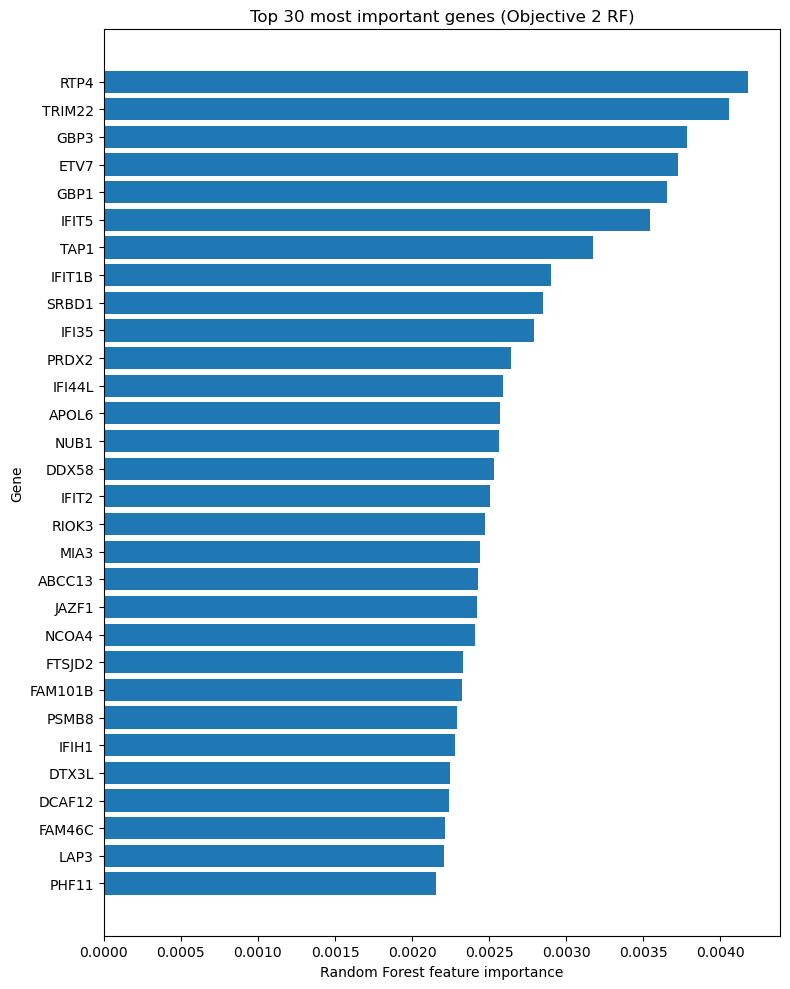

Saved -> rf_obj2_top30_genes_with_importance.csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assumes you already built gene_importance_df like:
# gene_importance_df = pd.DataFrame({"gene": selected_genes, "importance": importances}).sort_values(...)

# -----------------------------
# 1) Show the top N genes (table)
# -----------------------------
TOP_N = 30
top_df = gene_importance_df.head(TOP_N).copy()
top_df["importance"] = top_df["importance"].astype(float)

print(top_df.to_string(index=False))

# -----------------------------
# 2) Plot the top N genes (barh)
# -----------------------------
plt.figure(figsize=(8, 10))
plt.barh(top_df["gene"][::-1], top_df["importance"][::-1])
plt.xlabel("Random Forest feature importance")
plt.ylabel("Gene")
plt.title(f"Top {TOP_N} most important genes (Objective 2 RF)")
plt.tight_layout()
plt.show()

# -----------------------------
# 3) Save top genes list (optional)
# -----------------------------
top_df.to_csv(f"rf_obj2_top{TOP_N}_genes_with_importance.csv", index=False)
print(f"Saved -> rf_obj2_top{TOP_N}_genes_with_importance.csv")

In [ ]:
print(type(X2_tr), X2_tr.shape)
print("dtype:", X2_tr.columns.dtype)
print("first 20 cols:", list(X2_tr.columns[:20]))
print("numeric-looking:", sum(str(c).isdigit() for c in X2_tr.columns), "of", X2_tr.shape[1])

<class 'pandas.core.frame.DataFrame'> (383, 11222)
dtype: object
first 20 cols: ['A4GALT', 'AAA1', 'AACS', 'AAGAB', 'AAK1', 'AAMP', 'AARS', 'AARS2', 'AASDH', 'AASDHPPT', 'AATF', 'AATK', 'ABAT', 'ABCA1', 'ABCA13', 'ABCA5', 'ABCA7', 'ABCB1', 'ABCB10', 'ABCB7']
numeric-looking: 0 of 11222


us erandom forest as model for survival -> paper (link)